In [2]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import sys

sys.path.append("../includes")

import models
import utils

import imageio
import imageio_ffmpeg

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load images

1f347
1f951


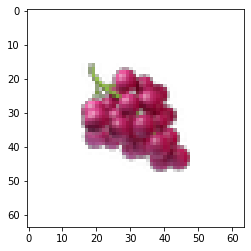

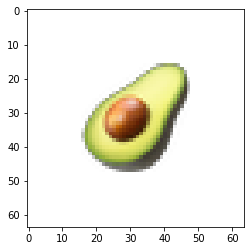

In [3]:
image_1 = utils.load_emoji("🍇", 32, 16).to(device)
image_2 = utils.load_emoji("🥑", 32, 16).to(device)

plt.imshow(image_1.transpose(0, 2).cpu())
plt.show()
plt.imshow(image_2.transpose(0, 2).cpu())
plt.show()

img_size = 64

# Initialize model

In [4]:
n_channels = 16
n_epochs = 10000
lr = 0.001 # learning rate
pool_size = 1024 # number of states to store in the pool
batch_size = 16
hidden_size = 64 # size of the hidden layer in the perception network

model = models.Automata((64, 64), n_channels, hidden_size, device).to(device)

# Initialize pool

In [5]:
images = torch.stack([image_1, image_2])

# initialize pool with seeds
seed = torch.zeros(n_channels, img_size, img_size).to(device)
seed[3:, 32, 32] = 1

seed_1 = seed.clone()
seed_2 = seed.clone()

# flip the 5th value in the first seed
seed_1[4, 32, 32] = 0

seeds = torch.stack([seed_1, seed_2])

pool_initials = seeds.repeat(pool_size//2, 1, 1, 1)
pool_targets = images.repeat(pool_size//2, 1, 1, 1)

pool_target_ids = torch.Tensor([0, 1]).repeat(pool_size//2).long()
# 0 for image_1, 1 for image_2
# half image 1, half image 2

# Train model

In [6]:
losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = random.randint(96, 128)

    # indices to select from the pool
    pool_indices = torch.Tensor(random.sample(
        range(pool_size), batch_size)).long()

    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    
    # the target types (image_1 or image_2)
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states, iterations)

    # first four channels, to match the target images
    phenotypes = out[:, :4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)

    # first calculate loss per seed so we can 
    # sort later
    per_sample_loss = loss.mean((1, 2, 3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()

    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()

    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:1]
    max_loss_indices = ranked_loss[1:]

    replacements = out.detach()

    max_loss_targets = target_ids[max_loss_indices]

    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image

    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements

    # logging and checkpointing
    if i % 100 == 0:

        print(i, np.log10(float(total_loss.cpu().detach())))

        torch.save(model.state_dict(), "../models/divergence_"+str(i))

    losses.append(float(total_loss))

0 -1.144116765595038
100 -1.4831160112259614
200 -1.7901544347366016
300 -1.9444793846446347
400 -2.0491088881981794
500 -1.9946525868440028
600 -2.043815735103039
700 -2.1674961968999105
800 -2.300485972427117
900 -2.1494640824064635
1000 -2.3306054648412147
1100 -2.0804221720647114
1200 -2.1987734004994586
1300 -2.2551371725076454
1400 -2.323478997566403
1500 -2.383858796717439
1600 -2.4184405312072403
1700 -2.405593490889884
1800 -2.2822055259013734
1900 -2.4830050734916074
2000 -2.435795461407368
2100 -2.3674377308176604
2200 -2.454759643470266
2300 -2.5033289636480336
2400 -2.5075628275659443
2500 -2.553826969343856
2600 -2.559447528955689
2700 -2.4678428736131073
2800 -2.6222313351593645
2900 -2.5467109678229125
3000 -2.5701593559157736
3100 -2.5177219043619536
3200 -2.6295081616055627
3300 -2.285519032021192
3400 -2.4558460012467913
3500 -2.605491725605367
3600 -2.6602606922394703
3700 -2.6777601607677473
3800 -2.6857286285683575
3900 -2.6748926667445403
4000 -2.7344278246229585

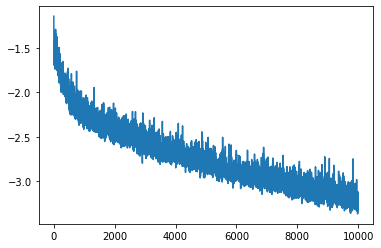

In [7]:
plt.plot(np.log10(losses))

# Load model checkpoint

In [8]:
model.load_state_dict(
    torch.load("../models/divergence_9900", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [9]:
seed_mix = seed.clone()
seed_mix[4, 32, 32] = 0.5

# Make videos

In [10]:
video = utils.get_model_history(model, seed_1, 128)
utils.channels_to_gif("../videos/divergence_seed_1_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_1_colors.gif", video)

video = utils.get_model_history(model, seed_2, 128)
utils.channels_to_gif("../videos/divergence_seed_2_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_2_colors.gif", video)

video = utils.get_model_history(model, seed_mix, 128)
utils.channels_to_gif("../videos/divergence_seed_mix_channels.gif", video)
utils.colors_to_gif("../videos/divergence_seed_mix_colors.gif", video)

/home/khu/.cache/pypoetry/virtualenvs/neural-automata-mPApKxAd-py3.7/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
